# Topic Modeling of American News Articles Using LDA

Created by Patrick Steeves for Independent Study with Professor Kanungo <br>
George Washington University 12/23/2017

### Setting up

In [1]:
%matplotlib inline

In [3]:
from gensim.models import LdaModel
import logging
import pandas as pd
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
import time
import numpy as np

C:\Users\patri\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
path = 'C:\\Users\\patri\\Documents\\GW\\2017Fall\\Independent Study\\Project 2\\Data\\'

### <br> <br> Data import and cleaning

The data we have is collected from Kaggle at https://www.kaggle.com/snapcrack/all-the-news <br>
It contains 143,000 articles and is available for download as 3 files: articles1.csv, articles2.csv, articles3.csv

Import data from CSV files and keep relevant columns

In [ ]:
from urllib.request import urlretrieve 
url = "https://github.com/psteeves/NLP-projects/raw/master/LDA%20Topic%20Model/Data/"
filename, headers = urlretrieve(url+'articles0.zip')
filename

In [5]:
def importData():
    url = "https://github.com/psteeves/NLP-projects/raw/master/LDA%20Topic%20Model/Data/"

    textnums = range(14)   # Number of files to import
    temp = []
    for i in textnums:
        print("Importing and unzipping file {}...".format(i))
        file = 'articles'+str(i)+'.zip'
        filename, headers = urllib.request.urlretrieve(url+file, filename=file)
        zip_ref = zipfile.ZipFile(file, 'r')
        zip_ref.extractall()
        zip_ref.close()

        temp.append(pd.read_csv(file.replace('zip','csv'), encoding = 'latin1')
    data = pd.concat(temp).reset_index(drop=True)

    print("Computing word counts")
    data['word_count'] = data.content.apply(lambda x: len(x.split()))
    data = data.drop(['Unnamed: 0','id','author','date','year','month','url'],axis=1)
    return data

Remove all non alphabetical characters, tokenize words, lemmatize words, and filter out stop words

In [6]:
def cleanData(data,text_column):
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')

    start = time.time()
    print("Starting cleaning...")
    data['cleaned_content'] = [re.sub('[^a-zA-Z]+',' ', text).lower() for text in data[text_column]]   # Only keep alphabetical data
    print("Starting tokenizing...")
    data['tokens'] = [tokenizer.tokenize(text) for text in data['cleaned_content']]
    print("Starting lemmatizing and filtering...")
    data['tokens'] = [[lemmatizer.lemmatize(token) for token in text if len(token) > 1 and token not in stopwords.words('english')] for text in data['tokens']]

    print("Took {:.0f} seconds to clean texts".format(time.time()-start))
    data.drop()
    data.to_csv(path+'clean_articles.csv', index=False)
    return data

Import news articles from CSV

Importing file 1...
Importing file 2...
Importing file 3...
Computing word counts


(array([ 14603.,  29646.,  27948.,  23223.,  16881.,  10268.,   6832.,
          4111.,   2558.,   1609.]),
 array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000]),
 <a list of 10 Patch objects>)

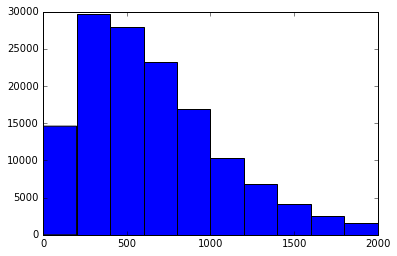

In [7]:
data = importData()
plt.hist(data.word_count, bins=[0,200,400,600,800,1000,1200,1400,1600,1800,2000])

Look at word count distributions. Only consider articles between 200 and 700 words in length for limited RAM

In [8]:
data = data.loc[data['word_count'] > 199,:]
data = data.loc[data['word_count'] < 701,:].reset_index(drop=True)
clean_articles = cleanData(data,'content')
del(data)

Starting cleaning...
Starting tokenizing...
Starting lemmatizing and filtering...
Took 11619 seconds to clean texts


Let's take a look at our data

In [9]:
clean_articles.iloc[:3,:]

,title,publication,content,word_count,cleaned_content,tokens
0,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,"SEOUL, South Korea — North Korea’s leader, ...",694,seoul south korea north korea s leader kim sai...,"[seoul, south, korea, north, korea, leader, ki..."
1,Taiwan’s President Accuses China of Renewed In...,New York Times,BEIJING — President Tsai of Taiwan sharpl...,571,beijing president tsai of taiwan sharply criti...,"[beijing, president, tsai, taiwan, sharply, cr..."
2,How to form healthy habits in your 20s - The N...,New York Times,This article is part of a series aimed at help...,665,this article is part of a series aimed at help...,"[article, part, series, aimed, helping, naviga..."


Add bigrams to articles

In [10]:
def addBigrams(df, token_column):
    phrases = Phrases(df[token_column], min_count = 250)
    bigrams = Phraser(phrases)
    for idx in range(len(df[token_column])):
        for token in bigrams[df[token_column][idx]]:
            if '_' in token:
                df[token_column][idx].append(token)
    return bigrams, df

In [11]:
bigrams, complete_data = addBigrams(clean_articles, 'tokens')
del(clean_articles)

Illustrate how bigrams work. When fed a list of tokens (words), if two of the words form a bigram present in at least 250 of our articles, it is returned as one word separated by a hyphen

In [44]:
print(bigrams['new','york','north','korea', 'new','haven'])

['new_york', 'north_korea', 'new', 'haven']


Create bag of words representation for articles

In [13]:
def createBOW(df,token_column):
    dictionary = Dictionary(df.loc[:,token_column])   # Assign words to numeric ID
    dictionary.filter_extremes(no_below = 200, no_above = 0.6)   # Only keep words that were present in more than 200 documents and fewer than 60% of them
    df['bow'] = [dictionary.doc2bow(doc) for doc in df[token_column]]    # Create BOW column
    df.to_csv(path+'training_data.csv')
    return df, dictionary

In [14]:
training_data, dictionary = createBOW(complete_data, 'tokens')

Our data is now ready to train the LDA model

In [15]:
training_data.iloc[10:13,:]

,title,publication,content,word_count,cleaned_content,tokens,bow
10,Chinese City Official Shoots 2 Others and Kill...,New York Times,BEIJING — A city official in southwest Chin...,358,beijing a city official in southwest china unl...,"[beijing, city, official, southwest, china, un...","[(11, 1), (16, 1), (54, 2), (73, 1), (79, 4), ..."
11,Ivanka Trump’s New Washington Home Once Belong...,New York Times,"WASHINGTON — Ivanka Trump, who is weighing ...",683,washington ivanka trump who is weighing a prom...,"[washington, ivanka, trump, weighing, prominen...","[(51, 1), (55, 3), (60, 1), (69, 1), (71, 1), ..."
12,How We Put Together Our 52 Places to Go List -...,New York Times,"For the 12th straight year, the Travel section...",567,for the th straight year the travel section pr...,"[th, straight, year, travel, section, present,...","[(38, 2), (60, 1), (84, 1), (108, 1), (161, 1)..."


### <br><br> LDA Model

Check that our dictionary is filled

In [45]:
dictionary[0]

'associate'

Create dict with word definitions to be used in LDA training

In [19]:
id2word = dictionary.id2token

In [21]:
print("Our training data has {} distinct words".format(len(dictionary)))
print("Our corpus has {} documents".format(len(training_data)))

Our training data has 8096 distinct words
Our corpus has 69934 documents


Set parameters for LDA model training

In [22]:
num_topics = 20
chunksize = 9000
passes = 15
iterations = 400

Time to train model!

In [23]:
start = time.time()
model = LdaModel(corpus = training_data['bow'], num_topics = num_topics, id2word = id2word, chunksize = chunksize, iterations = iterations, passes = passes)
print("Took {} seconds to train model".format(time.time()-start))

Took 5416.5155465602875 seconds to train model


Print resulting topics. As we can see, our documents can contain any of 20 distinct topics that can be easily intepreted by the most common words in the topics, which are printed below

In [24]:
for i in range(num_topics):
    print(model.print_topic(i,topn=30)+'\n')

0.022*"state" + 0.020*"court" + 0.018*"law" + 0.013*"federal" + 0.009*"new" + 0.009*"case" + 0.008*"judge" + 0.008*"right" + 0.008*"government" + 0.008*"order" + 0.007*"justice" + 0.007*"would" + 0.007*"rule" + 0.007*"department" + 0.006*"decision" + 0.006*"legal" + 0.005*"public" + 0.005*"ban" + 0.005*"lawsuit" + 0.005*"executive" + 0.004*"attorney" + 0.004*"supreme" + 0.004*"statement" + 0.004*"supreme_court" + 0.004*"district" + 0.004*"appeal" + 0.004*"use" + 0.004*"governor" + 0.004*"administration" + 0.004*"ruling"

0.014*"state" + 0.010*"military" + 0.009*"attack" + 0.008*"force" + 0.008*"syria" + 0.007*"islamic" + 0.007*"north" + 0.007*"war" + 0.007*"korea" + 0.006*"united" + 0.006*"government" + 0.006*"group" + 0.006*"iran" + 0.006*"country" + 0.006*"syrian" + 0.005*"islamic_state" + 0.005*"official" + 0.005*"nuclear" + 0.005*"security" + 0.005*"isi" + 0.005*"u" + 0.005*"russia" + 0.005*"north_korea" + 0.005*"united_state" + 0.004*"iraq" + 0.004*"missile" + 0.004*"south" + 0.00

For each of our documents, topic probability distribution

In [25]:
training_data['topics'] = training_data.bow.apply(lambda x: model.get_document_topics(x, minimum_probability = 1e-8))

This function returns tuples with topic ID and prob. We can keep only the probabilities

In [26]:
training_data['topics'] = [np.array([prob[1] for prob in row]) for row in training_data.topics]

In [27]:
training_data.iloc[18:20,:]

,title,publication,content,word_count,cleaned_content,tokens,bow,topics
18,2 Credit-Reporting Agencies Must Pay $23 Milli...,New York Times,The nation’s consumer watchdog agency on Tuesd...,340,the nation s consumer watchdog agency on tuesd...,"[nation, consumer, watchdog, agency, tuesday, ...","[(47, 1), (324, 1), (490, 1), (502, 1), (585, ...","[0.269334122173, 0.000340136059492, 0.06643992..."
19,Chase Sapphire Reserve Card’s Huge Bonus Will ...,New York Times,When a Wall Street banking institution starts ...,365,when a wall street banking institution starts ...,"[wall, street, banking, institution, start, th...","[(51, 2), (108, 1), (361, 1), (433, 1), (565, ...","[0.000270270275914, 0.000270270272897, 0.00027..."


### <br><br>Recommending further reading

This function returns the second, third, and fourth smallest numbers from an array. It will be used to find most similar topic  PDFs (the most similar one will be itself, with a difference of 0)

In [28]:
def smallestNums(series):
    position1 = None
    position2 = None    # position of 2nd smallest num
    position3 = None    # position of 3rd smallest num
    position4 = None    # position of 4th smallest num
    step = 0
    m1, m2, m3, m4 = float('inf'), float('inf'), float('inf'), float('inf')
    for num in series:
        if num <= m1:     # If number is less than current minimum, minimum to be number
            m1, m2, m3, m4 = num, m1, m2, m3
            position4 = position3
            position3 = position2
            position2 = position1
            position1 = step
        elif num < m2:    # If not smaller than minimum, but smaller than second smallest number, update second smallest number
            m2, m3, m4 = num, m2, m3
            position4 = position3
            position3 = position2
            position2 = step
        elif num < m3:    # If not smaller than minimum, but smaller than second smallest number, update second smallest number
            m3, m4 = num, m3
            position4 = position3
            position3 = step
        elif num < m4:
            m4 = num
            position4 = step
        step += 1
    return position2, position3, position4

In [29]:
def similarArticle(articlenum):
    pdf = training_data.iloc[articlenum,7]
    diff = training_data.topics.apply(lambda x: np.linalg.norm(pdf - x))   #For each article, calculate distance to pdf of article of interest
    return smallestNums(diff)

<br>Let's try an example. Pick a random text, say the 1112th one in our corpus

In [42]:
article1 = 1111
training_data.iloc[article1,2]

'The veteran television personality Jane Pauley will replace Charles Osgood as the anchor of the highly rated CBS show “Sunday Morning. ” Mr. Osgood, who is retiring, announced the news on his last show on Sunday. Ms. Pauley’s first day in the role will be Oct. 9, and she will become only the third anchor of the show, which started in 1979. For Ms. Pauley, 65, a return to the anchor role for a morning television show represents an unexpected   comeback. And by selecting her instead of a younger    CBS is clearly trying to ease the transition from Mr. Osgood, 83, whose folksy delivery has been a mainstay on the show for more than two decades. In a statement, the president of CBS News, David Rhodes, said, “Charles Osgood is a television news legend  —   and so is Jane Pauley. ” Ms. Pauley first catapulted to fame at age 25 when she replaced Barbara Walters as an anchor of the “Today” show 40 years ago. She remained with “Today” through the late 1980s until the notoriously messy handoff i

In [43]:
similar1, similar2, similar3 = similarArticle(article1)
print(training_data.iloc[similar1,2][:2000])
print('\n')
print(training_data.iloc[similar2,2][:2000])
print('\n')
print(training_data.iloc[similar3,2][:2000])

Arnold Schwarzenegger’s debut as the new boss of NBC’s New Celebrity Apprentice drew soft ratings Monday night without its longtime host and current   Donald Trump. [The season premiere of Celebrity Apprentice drew an average of 4. 9 million viewers and a 1. 3 rating in the     demo, according to the Hollywood Reporter. The outlet notes those numbers are down a significant 35 percent from last year’s Donald   premiere of the show.  NBC did heavy promotion for the new Apprentice, with TV spots highlighting a     Schwarzenegger poised to take over the boss position played by Trump for 14 seasons. The network also teased Schwarzenegger’s replacement line for Trump’s “You’re fired” Schwarzenegger’s updated catchphrase, revealed on Monday night’s episode, is “You’re terminated. ” The show also drew some buzz when it was reported that Trump would retain his executive producer credit on the show (though he said he would not have any involvement in it whatsoever). Neither factor appeared to he

<br>Nice! The algorithm returns articles about pop culture that reference Trump. Let's try another one..

In [34]:
article2 = 9843
training_data.iloc[article2,2]

'The Wall Street Journal’s Potomac Watch columnist Kimberley Strassel details the “devastating case against a Clinton presidency” that can be made by reviewing the WikiLeaks documents combined with what is already known in the public record. Strassel notes that although “the nation now has proof of pretty much everything [Hillary Clinton] has been accused of,” the media “has almost uniformly ignored the flurry of bombshells, preferring to devote its front pages” to the story that Donald Trump “made lewd remarks a decade ago and now stands accused of groping women. ”[ From Strassel in the Wall Street Journal:  The Obama administration —  the federal government, supported by tax dollars —  was working as an extension of the Clinton campaign. The State Department coordinated with her staff in responding to the email scandal, and the Justice Department kept her team informed about developments in the court case. Worse, Mrs. Clinton’s State Department, as documents obtained under the Freedo

In [39]:
similar1, similar2, similar3 = similarArticle(article2)
print(training_data.iloc[similar1,2][:2000])
print('\n')
print(training_data.iloc[similar2,2][:2000])
print('\n')
print(training_data.iloc[similar3,2][:2000])

Democratic presidential nominee Hillary Clinton told Fox News’ Chris Wallace that she is “really proud” of her family’s charity the Clinton Foundation  —   after spending the past week hiding its existence from viewers of the Democratic National Convention. [The glaring contradiction prompted a video comparison, which you can watch above.  Wallace, in an exclusive   interview, asked Clinton about allegations first made in Clinton Cash, the book and now   novel, that Clinton used the    charity for international “  ” deals while she served as Secretary of State. Author and Breitbart News Senior    Peter Schweizer says that Clinton Foundation donors were on the receiving end of corrupt deals approved by Hillary’s State Department  —   including the sale of U. S. uranium to Russia and a rare, lucrative mining permit in Haiti. Clinton retorted that she is “really proud of the Clinton Foundation,” yet not a single speaker at the DNC last week  —   not even Bill or Chelsea Clinton  —   menti

This process is very quick and doesn't take more than a few seconds to run